In [33]:
import time
start_time = time.time()

In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

# After downloading Air-Pollution-Image-Dataset-From-India-and-Nepal dataset from kaggle, extract it and pass the path for all the respective csv file for training, validation and test.

In [35]:
# Specify the file paths for the training, validation, and testing CSV files
train_csv_file = './archive/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/train_data.csv'  # Replace with the path to your training CSV file
val_csv_file = './archive/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/val_data.csv'  # Replace with the path to your validation CSV file
test_csv_file = './archive/Dataset_for_AQI_Classification/Dataset_for_AQI_Classification/testing_data.csv'  # Replace with the path to your testing CSV file


In [36]:
# Read the training CSV file into a DataFrame
train_df = pd.read_csv(train_csv_file)
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# train_df = train_df.head(int(0.0025 * train_df.shape[0]))

# Read the validation CSV file into a DataFrame
val_df = pd.read_csv(val_csv_file)

# Read the testing CSV file into a DataFrame
test_df = pd.read_csv(test_csv_file)

# Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)


# Create data generators
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory='./archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img',                             # Change the directory to your downloaded dataset path
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    directory='./archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img',                             # Change the directory to your downloaded dataset path
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    directory='./archive/Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img',                             # Change the directory to your downloaded dataset path
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical'
)

Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# write your code here to create and train your model for image classificatoin for AQI class

In [37]:
from keras.layers import LeakyReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import tensorflow
# define your model here
# Create a Sequential model

# num_classes = 6

# model = Sequential()
# # Block 1
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # Block 2
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # Block 3
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # Block 4
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # Block 5
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# # FC layers
# model.add(Flatten())
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

num_classes = 6

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model = tensorflow.keras.Sequential([
    base_model,
    tensorflow.keras.layers.GlobalAveragePooling2D(),
    tensorflow.keras.layers.Dense(1024, activation='relu'),
    tensorflow.keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
import tensorflow as tf
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.cast(K.argmax(y_true, axis=-1), dtype=tf.float32)
        y_pred = K.cast(K.argmax(y_pred, axis=-1), dtype=tf.float32)
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        false_pos = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
        false_neg = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
        self.true_positives.assign_add(true_pos)
        self.false_positives.assign_add(false_pos)
        self.false_negatives.assign_add(false_neg)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1_score

In [39]:
#compile your model here

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
learning_rate = 0.001
momentum = 0.9
model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])

In [40]:
#train you model here
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# history = model.fit(train_generator, epochs=5, validation_data=val_generator)
history = model.fit(train_generator, epochs=100, validation_data=val_generator, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
245/245 [==============================] - 695s 3s/step - loss: 0.6707 - accuracy: 0.7569 - f1_score: 0.8739 - val_loss: 2.0282 - val_accuracy: 0.2695 - val_f1_score: 0.4328
Epoch 2/100
245/245 [==============================] - 689s 3s/step - loss: 0.1471 - accuracy: 0.9580 - f1_score: 0.9763 - val_loss: 1.8270 - val_accuracy: 0.4267 - val_f1_score: 0.6985
Epoch 3/100
245/245 [==============================] - 714s 3s/step - loss: 0.0542 - accuracy: 0.9885 - f1_score: 0.9935 - val_loss: 1.7097 - val_accuracy: 0.4472 - val_f1_score: 0.7255
Epoch 4/100
245/245 [==============================] - 763s 3s/step - loss: 0.0335 - accuracy: 0.9918 - f1_score: 0.9953 - val_loss: 1.3745 - val_accuracy: 0.5860 - val_f1_score: 0.7812
Epoch 5/100
245/245 [==============================] - 730s 3s/step - loss: 0.0153 - accuracy: 0.9973 - f1_score: 0.9985 - val_loss: 1.0893 - val_accuracy: 0.7044 - val_f1_score: 0.8465
Epoch 6/100
245/245 [==============================] - 728s 3s/step - 

# plot your Training Accuracy and validation accuracy here

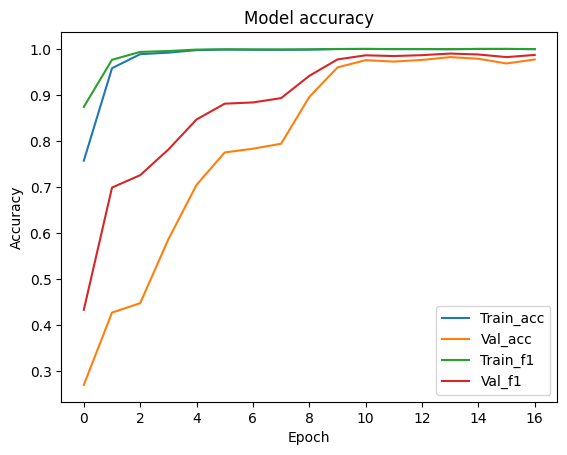

In [41]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Val_acc', 'Train_f1', 'Val_f1'], loc='lower right')
plt.show()

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [42]:
test_probabilities = model.predict(test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
# test_probabilities_df.to_csv('/kaggle/working/test_results.csv', index=False)
test_probabilities_df.to_csv('./submission_local_14.csv', index=False)


77/77 [==============================] - 41s 521ms/step


In [50]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy, f1 = model.evaluate(test_generator)
# test_result = model.evaluate(test_generator)
# test_loss = test_result[0]
# test_accuracy = test_result[1]

# Generate predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)


77/77 [==============================] - 47s 603ms/step


In [51]:
# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 scores for each class
for i, f1 in enumerate(f1_scores):
    print("Class {}: F1 Score = {:.4f}".format(i, f1))

# Print the average F1 score
print("Average F1 Score: {:.4f}".format(average_f1_score))
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))

Class 0: F1 Score = 0.1194
Class 1: F1 Score = 0.1180
Class 2: F1 Score = 0.2355
Class 3: F1 Score = 0.2210
Class 4: F1 Score = 0.1767
Class 5: F1 Score = 0.0796
Average F1 Score: 0.1583

Test Accuracy: 0.9943


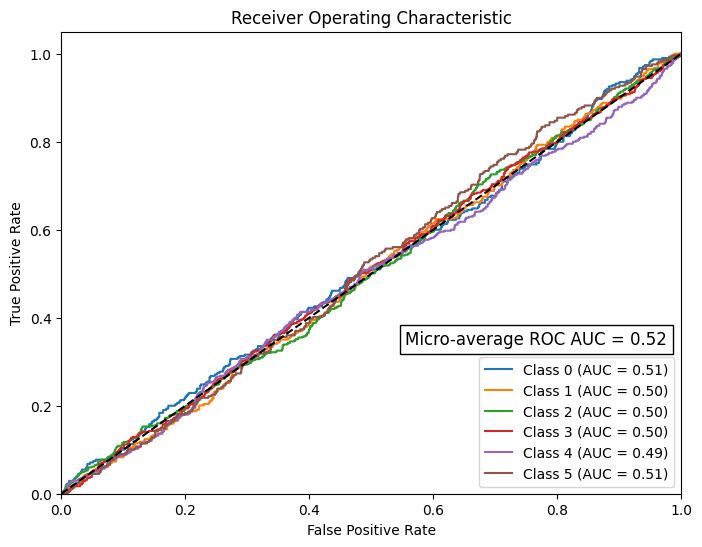

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

# Calculate the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_pred_prob, average='micro')

# Plot the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random chance curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add micro-average ROC AUC score to the plot
plt.text(0.555, 0.34, 'Micro-average ROC AUC = %0.2f' % roc_auc_scores, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = model.predict(train_generator)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = model.predict(val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = model.predict(test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

77/77 [==============================] - 53s 680ms/step
Overall MAE - Training: 1.7011
Overall RMSE - Training: 2.1309
Overall MAE - Validation: 1.7519
Overall RMSE - Validation: 2.1633
Overall MAE - Testing: 1.7455
Overall RMSE - Testing: 2.1645


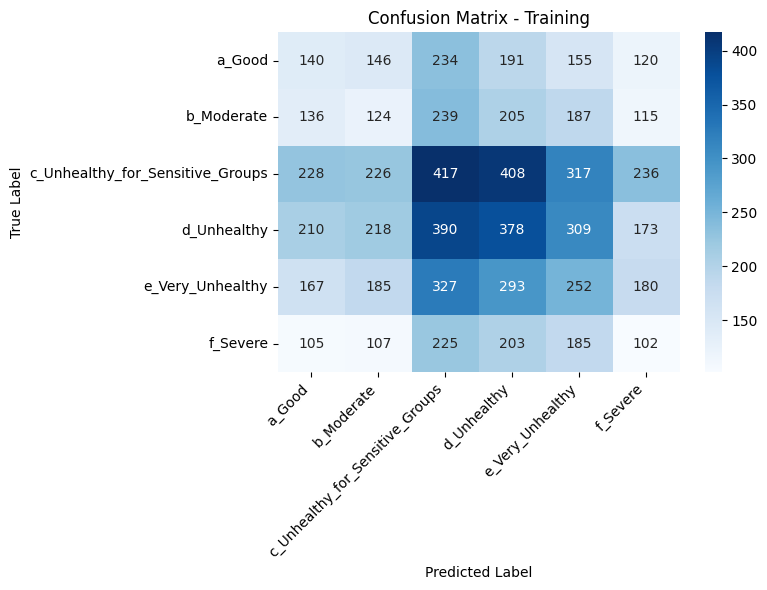

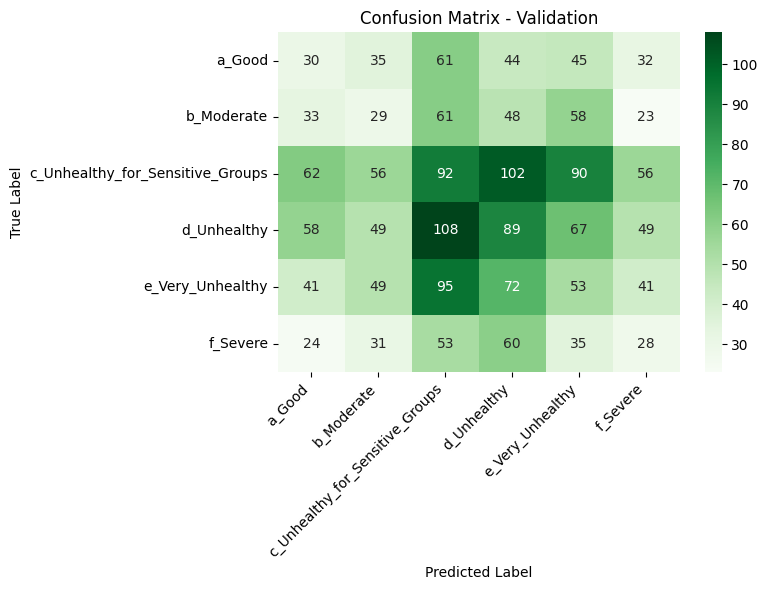

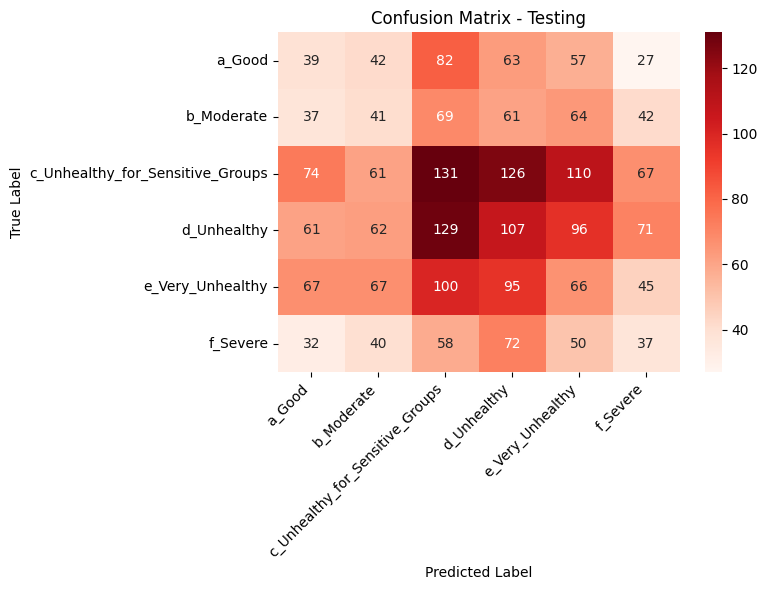

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [55]:
end_time = time.time()
execution_time = end_time - start_time
execution_time_minutes = execution_time / 60
execution_time_hours = execution_time / 3600
print("execution_time:", execution_time)
print("execution_time_minutes:", execution_time_minutes, "min")
print("execution_time_hours:", execution_time_hours, "hr")

execution_time: 33135.600841999054
execution_time_minutes: 552.2600140333176 min
execution_time_hours: 9.20433356722196 hr
